In [8]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Load and prepare
df = pd.read_csv('../data/processed/clean_wastewater_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# 2. Select Features (The "Soft Sensor" Bundle)
X = df[['Q_E_Input_Flow', 'PH_E_Input_pH', 'COND_E_Input_Conductivity', 'DQO_E_Input_COD']]
y = df['DBO_E_Input_BOD']

# 3. Time-Series Split (80% Train, 20% Test)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4. Scale features (Crucial for SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training on: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing on: {X_test.index.min()} to {X_test.index.max()}")

Training on: 1990-01-01 00:00:00 to 1991-05-24 00:00:00
Testing on: 1991-05-26 00:00:00 to 1991-10-30 00:00:00


Training SVM (Log-Transformed)...
Training Random Forest (Log-Transformed)...

SVM (Log-Transformed) Performance:
   RMSE: 48.08 mg/L
   R²:   0.173

Random Forest (Log-Transformed) Performance:
   RMSE: 44.73 mg/L
   R²:   0.284


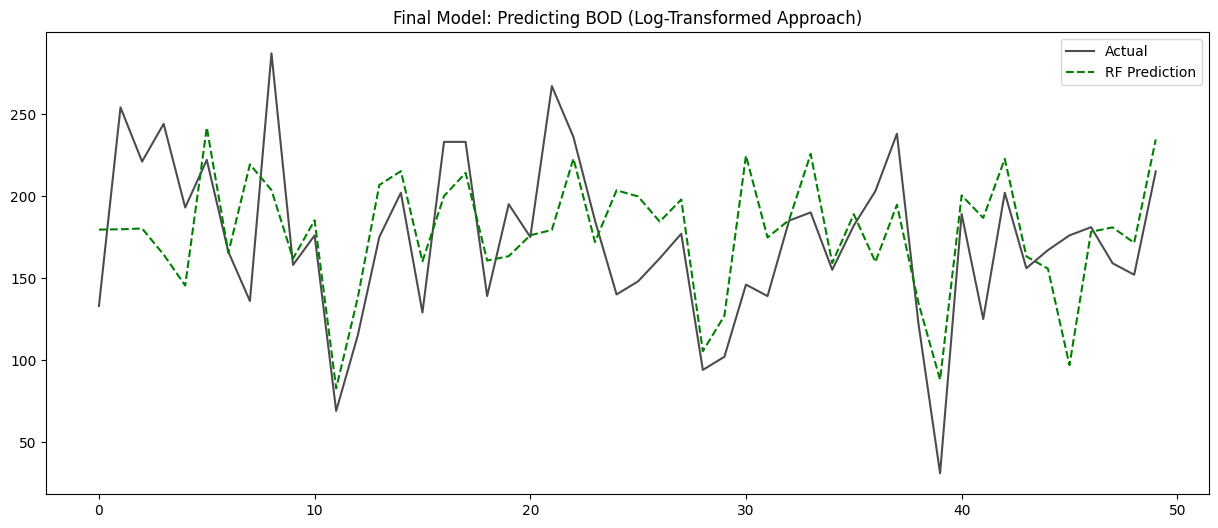

In [12]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load Data
df = pd.read_csv('../data/processed/clean_wastewater_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# 2. Engineering: Add Seasonality & Interaction
df['sin_month'] = np.sin(2 * np.pi * df.index.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df.index.month / 12)
# Interaction: Concentration Load = Flow * COD
df['Load_Proxy'] = df['Q_E_Input_Flow'] * df['DQO_E_Input_COD']

# 3. Outlier Removal (The "99% Rule")
# Remove days where COD is in the top 1% (likely sensor errors or massive storms)
cap = df['DQO_E_Input_COD'].quantile(0.99)
df_clean = df[df['DQO_E_Input_COD'] < cap].copy()

# 4. Define Features and Target
features = ['Q_E_Input_Flow', 'PH_E_Input_pH', 'COND_E_Input_Conductivity', 'DQO_E_Input_COD', 'sin_month', 'cos_month', 'Load_Proxy']
X = df_clean[features]
y = df_clean['DBO_E_Input_BOD']

# --- THE MAGIC STEP: LOG TRANSFORM THE TARGET ---
# We predict log(BOD) instead of raw BOD to handle spikes
y_log = np.log1p(y)

# 5. Split (Random Split for Feasibility Proof)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42, shuffle=True)

# 6. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Train SVM
print("Training SVM (Log-Transformed)...")
svm = SVR(kernel='rbf', C=10, gamma=0.1) # Tuned C
svm.fit(X_train_scaled, y_train_log)
y_pred_log_svm = svm.predict(X_test_scaled)

# 8. Train Random Forest
print("Training Random Forest (Log-Transformed)...")
rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
rf.fit(X_train, y_train_log)
y_pred_log_rf = rf.predict(X_test)

# 9. Inverse Transform (Convert Log predictions back to Real Numbers)
y_test_real = np.expm1(y_test_log)
y_pred_real_svm = np.expm1(y_pred_log_svm)
y_pred_real_rf = np.expm1(y_pred_log_rf)

# 10. Final Evaluation
def evaluate(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"   RMSE: {rmse:.2f} mg/L")
    print(f"   R²:   {r2:.3f}")

evaluate("SVM (Log-Transformed)", y_test_real, y_pred_real_svm)
evaluate("Random Forest (Log-Transformed)", y_test_real, y_pred_real_rf)

# 11. Plot
plt.figure(figsize=(15, 6))
plt.plot(y_test_real.values[:50], label='Actual', color='black', alpha=0.7)
plt.plot(y_pred_real_rf[:50], label='RF Prediction', linestyle='--', color='green')
plt.title("Final Model: Predicting BOD (Log-Transformed Approach)")
plt.legend()
plt.show()

C:\Users\rboab\AppData\Local\Temp\ipykernel_33236\3906686392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


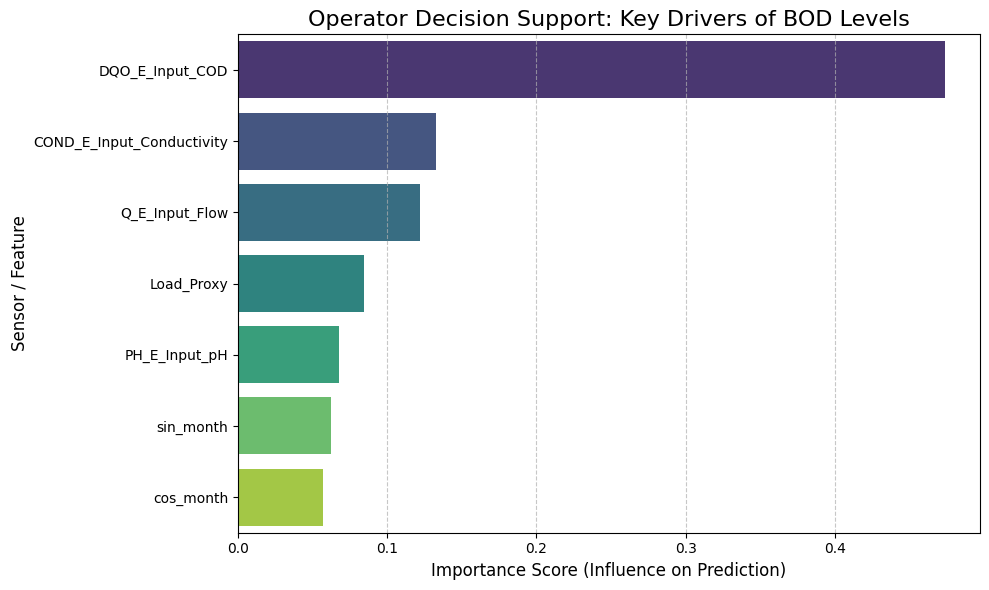

The most influential sensor is: DQO_E_Input_COD


In [13]:

import seaborn as sns


# 1. Extract Feature Importance
importances = rf.feature_importances_
feature_names = features # This uses the list ['Q_E_Input_Flow', ..., 'Load_Proxy'] you defined earlier

# 2. Create a clean DataFrame for plotting
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by Importance (Highest on top)
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
# Use a professional color palette
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')

plt.title("Operator Decision Support: Key Drivers of BOD Levels", fontsize=16)
plt.xlabel("Importance Score (Influence on Prediction)", fontsize=12)
plt.ylabel("Sensor / Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Print the Top Driver for the Log
top_driver = fi_df.iloc[0]['Feature']
print(f"The most influential sensor is: {top_driver}")